In [2]:
from typing import List, Dict, Tuple
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import matplotlib
from pathlib import Path
import matplotlib.pyplot as plt
import load_workload_data as ld
import load_benchmark_data as bn


sns.set(rc={'figure.figsize':(7.5,10)})

In [3]:
benchmark = "TPC-H"
single_threaded_folder = Path(f"../data/nemea_{benchmark}_sf10_singlethreaded")
multi_threaded_folder: Path = Path(f"../data/nemea_{benchmark}_sf10_multithreaded/")
sizes_folder: Path = Path(f"../data/nemea_{benchmark}_sf10_singlethreaded/")
high_level_mult: DataFrame = bn.get_high_level(multi_threaded_folder, sizes_folder)
low_level_mult: DataFrame = bn.get_low_level(multi_threaded_folder)
high_level_single: DataFrame = bn.get_high_level(single_threaded_folder, sizes_folder)
low_level_single: DataFrame = bn.get_low_level(single_threaded_folder)
high_level_mult

,benchmark_run_name,Total Runtime (in seconds),avg_throughput,Library Name,Compression Scheme,with_lto,Clients,Scale Factor,multithreaded,float,int,string,Library Name_baseline,Total Runtime (in seconds)_baseline,int_baseline,Runtime Library / Runtime Baseline,size_to_baseline
0,./hyriseBenchmarkTPCH_CompactVector_14_sf10_sh...,38.014279,0.360805,CompactVector,bitpacking_compactvector,False,14,10,True,676386560.0,7.909348e+08,7.950671e+09,Dictionary,41.228798,1.372782e+09,0.922032,0.576155
1,./tpch_Dictionary_14_sf10_shuffled.json,41.228798,0.336834,Dictionary,dictionary_Hyrise,False,14,10,True,676386560.0,1.372782e+09,7.950671e+09,Dictionary,41.228798,1.372782e+09,1.000000,1.000000
2,./tpch_FrameOfReference_14_sf10_shuffled.json,38.446318,0.356780,FrameOfReference,for_Hyrise,False,14,10,True,676386560.0,9.912806e+08,7.950671e+09,Dictionary,41.228798,1.372782e+09,0.932511,0.722096
3,./tpch_SIMDCAI_14_sf10_shuffled.json,39.593418,0.346463,SIMDCAI,for_SIMDCAI_simd,False,14,10,True,676386560.0,6.464946e+08,7.950671e+09,Dictionary,41.228798,1.372782e+09,0.960334,0.470938
4,./tpch_TurboPFOR_14_sf10_shuffled.json,41.378711,0.331666,TurboPFOR,pfor_turboPFOR,False,14,10,True,676386560.0,6.514422e+08,7.950671e+09,Dictionary,41.228798,1.372782e+09,1.003636,0.474542
5,./tpch_TurboPFOR_bitpacking_14_sf10_shuffled.json,38.599272,0.355270,TurboPFOR_bitpacking,bitpacking_turboPFOR,False,14,10,True,676386560.0,6.557167e+08,7.950671e+09,Dictionary,41.228798,1.372782e+09,0.936221,0.477655
6,./tpch_Unencoded_14_sf10_shuffled.json,36.699680,0.374132,Unencoded,unencoded_Hyrise,False,14,10,True,676386560.0,1.266756e+09,7.950671e+09,Dictionary,41.228798,1.372782e+09,0.890147,0.922766
7,./hyriseBenchmarkTPCH_CompactVector_28_sf10_sh...,55.168860,0.497101,CompactVector,bitpacking_compactvector,False,28,10,True,676386560.0,7.909348e+08,7.950671e+09,Dictionary,60.205721,1.372782e+09,0.916339,0.576155
8,./tpch_Dictionary_28_sf10_shuffled.json,60.205721,0.460573,Dictionary,dictionary_Hyrise,False,28,10,True,676386560.0,1.372782e+09,7.950671e+09,Dictionary,60.205721,1.372782e+09,1.000000,1.000000
9,./tpch_FrameOfReference_28_sf10_shuffled.json,55.875643,0.490804,FrameOfReference,for_Hyrise,False,28,10,True,676386560.0,9.912806e+08,7.950671e+09,Dictionary,60.205721,1.372782e+09,0.928079,0.722096


## Runtime


In [4]:
def load_all_benchmakrs_high_multi(benchmark: str) -> DataFrame:
    sizes_folder: Path = Path(f"../data/nemea_{benchmark}_sf10_singlethreaded/")
    multi_threaded_folder: Path = Path(f"../data/nemea_{benchmark}_sf10_multithreaded/")
    df = bn.get_high_level(multi_threaded_folder, sizes_folder)
    df["Benchmark"] = [benchmark for i in range(0, len(df))]
    return df[df[bn.CLIENTS] == 28]

all_benchmarks: DataFrame = load_all_benchmakrs_high_multi("TPC-H")\
                                .append(load_all_benchmakrs_high_multi("TPC-DS"))\
                                .append(load_all_benchmakrs_high_multi("JOB"))

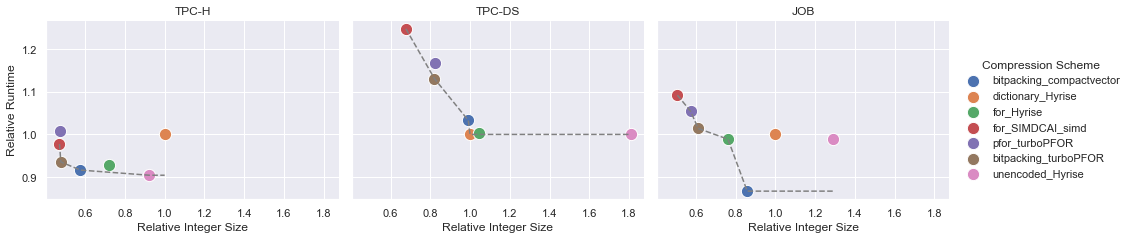

In [5]:
def pareto_frontier(Xs, Ys, maxX=False, maxY=False):
    '''Pareto frontier selection process'''
    sorted_list = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxY)
    pareto_front = [sorted_list[0]]
    for pair in sorted_list[1:]:
        if maxY:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
        else:
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)

    return pareto_front

def connect_dominated_points(ax, data: DataFrame, x: str, y: str):
    x_values = list(data[x])
    y_values = list(data[y])
    par: List[Tuple[int, int]] = pareto_frontier(x_values, y_values)
    #print(par)
    par.append([max(x_values), par[-1][1]])
    ax.plot([p[0] for p in par], [p[1] for p in par], color="grey", linestyle="dashed")

g = sns.FacetGrid(all_benchmarks, col="Benchmark", hue=bn.PAPER_NAME, legend_out=True, height=3.5, aspect=1.3)
g.map(sns.scatterplot, bn.SIZE_TO_BASELINE, bn.RUNTIME_TO_BASELINE, s=150)
g.set_axis_labels("Relative Integer Size", "Relative Runtime")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend()
#
for ax in g.axes.flatten():
    benchmark = ax.title.get_text()
    data_for_benchmark = all_benchmarks[all_benchmarks["Benchmark"] == benchmark]
    connect_dominated_points(ax, data=data_for_benchmark, x=bn.SIZE_TO_BASELINE, y=bn.RUNTIME_TO_BASELINE)

#plt.setp(g._legend.get_title(), fontsize=14.5)
#plt.setp(g._legend.get_texts(), fontsize=14.5)
    #plt.setp(ax.get_legend().get_texts(), fontsize=22)  # for legend text
    #plt.setp(ax.get_legend().get_title(), fontsize=22)  # for legend title

plt.savefig(f"visualizations/pareto_segment_encoding.svg", format="svg")


In [6]:
only_28_clients_mult = high_level_mult[high_level_mult[bn.CLIENTS] == 28]
columns_to_merge: List[str] = [bn.LIBRARY_NAME, bn.RUNTIME_TO_BASELINE, bn.SIZE_TO_BASELINE]
high_level_single[columns_to_merge].merge(only_28_clients_mult[columns_to_merge], on=[bn.LIBRARY_NAME, bn.SIZE_TO_BASELINE])

,Library Name,Runtime Library / Runtime Baseline _x,size_to_baseline,Runtime Library / Runtime Baseline _y
0,CompactVector,0.911075,0.576155,0.916339
1,Dictionary,1.000000,1.000000,1.000000
2,FrameOfReference,0.914850,0.722096,0.928079
3,SIMDCAI,0.950550,0.470938,0.977628
4,TurboPFOR_bitpacking,0.905303,0.477655,0.935553
5,TurboPFOR,0.960166,0.474542,1.007754
6,Unencoded,0.866277,0.922766,0.904288


In [7]:
def load_benchmark_low(benchmark: str) -> DataFrame:
    multi_threaded_folder: Path = Path(f"../data/nemea_{benchmark}_sf10_multithreaded/")
    low_level_mult: DataFrame = bn.get_low_level(multi_threaded_folder)
    low_level_mult["Benchmark"] = [benchmark for i in range(0, len(low_level_mult))]
    return low_level_mult[low_level_mult[bn.CLIENTS] == 28]

def plot_runtime(data, color=None):
    sns.boxplot(data=data, x=bn.PAPER_NAME, y=bn.RUNTIME_TO_BASELINE)
    plt.ylim(0.0, 3)
    plt.xticks(rotation=90)
    plt.axhline(y=1, color='r', linewidth=3, linestyle='--')

low_level_results = load_benchmark_low("TPC-H").append(load_benchmark_low("TPC-DS")).append(load_benchmark_low("JOB"))
low_level_results  = low_level_results[low_level_results[bn.LIBRARY_NAME] != "Dictionary"]

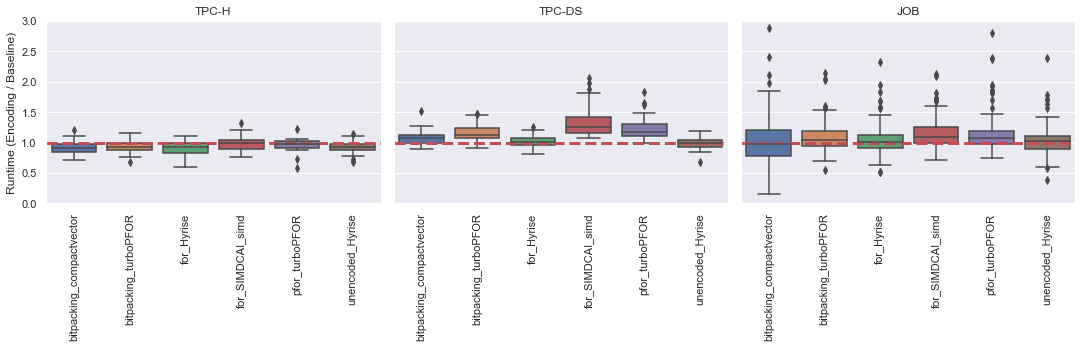

In [8]:
low_level_results = low_level_results.sort_values(by=[bn.PAPER_NAME])
grid = sns.FacetGrid(low_level_results, col="Benchmark", col_order=["TPC-H", "TPC-DS", "JOB"], height=5)
grid.map_dataframe(plot_runtime)
grid.set_titles(col_template="{col_name}")
grid.set_ylabels("Runtime (Encoding / Baseline)")
plt.savefig("visualizations/benchmarks_runtime.svg", bbox_inches="tight")

In [9]:
def load_segment_sizes(benchmark: str, libraries: List[str]) -> DataFrame:
    final_result: DataFrame = DataFrame()
    sizes_folder: Path = Path(f"../data/nemea_{benchmark}_sf10_singlethreaded/")
    dictionary: DataFrame = bn.load_sizes(sizes_folder / "sizes_Dictionary.txt")
    dictionary[bn.LIBRARY_NAME] = ["Dictionary" for i in range(0,len(dictionary))]
    dictionary[bn.PAPER_NAME] = [bn.fancy_name(lib) for lib in dictionary[bn.LIBRARY_NAME]]
    for library in libraries:
        integer_compressed: DataFrame = bn.load_sizes(sizes_folder / f"sizes_{library}.txt")
        integer_compressed[bn.LIBRARY_NAME] = [library for i in range(0,len(integer_compressed))]
        integer_compressed[bn.PAPER_NAME] = [bn.fancy_name(lib) for lib in integer_compressed[bn.LIBRARY_NAME]]
        columns_to_merge: List[str] = ["table_name", "chunk_id", "column_id", bn.SIZE_IN_BYTES, bn.LIBRARY_NAME, bn.PAPER_NAME]
        merged: DataFrame = integer_compressed.merge(dictionary[columns_to_merge], on=["table_name", "chunk_id", "column_id"],suffixes=("","_baseline"))
        merged[bn.SIZE_TO_BASELINE] = [x / y
                                     for x, y in zip(merged[bn.SIZE_IN_BYTES],
                                                     merged[f"{bn.SIZE_IN_BYTES}_baseline"])]
        int_columns = merged[merged[bn.DATA_TYPE] == "int"]
        final_result = final_result.append(int_columns)
    final_result["Benchmark"] = [benchmark for i in range(0,len(final_result))]
    return final_result

def plot_sizes(data, color=None):
    sns.boxplot(data=data, x=bn.PAPER_NAME, y=bn.SIZE_TO_BASELINE)
    plt.ylim(0.0, 8.0)
    plt.xticks([])
    plt.axhline(y=1, color='r', linewidth=3, linestyle='--')

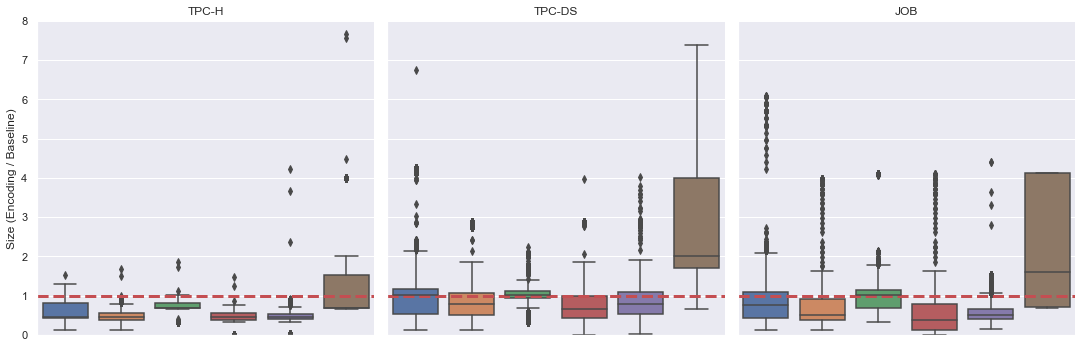

In [10]:
libraries: List[str] = list(high_level_mult[bn.LIBRARY_NAME].drop_duplicates())
libraries.remove("Dictionary")
sizes = load_segment_sizes("TPC-H", libraries).append(load_segment_sizes("TPC-DS", libraries)).append(load_segment_sizes("JOB", libraries))
sizes = sizes.sort_values(by=[bn.PAPER_NAME])
grid = sns.FacetGrid(sizes, col="Benchmark", col_order=["TPC-H", "TPC-DS", "JOB"], height=5)
grid.map_dataframe(plot_sizes)
grid.set_xlabels("")
grid.set_ylabels("Size (Encoding / Baseline)")
grid.set_titles(col_template="{col_name}")
plt.savefig("visualizations/benchmarks_size.svg", bbox_inches="tight")

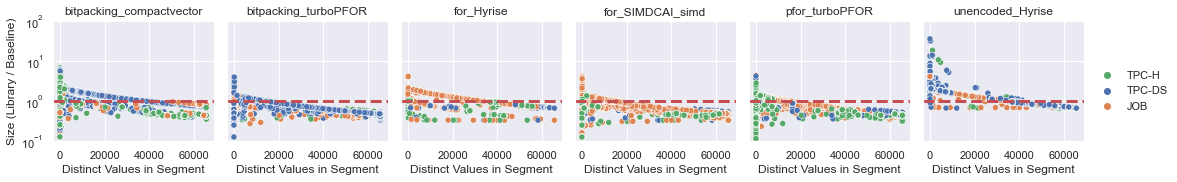

In [11]:
only_one_benchmark = sizes[sizes["Benchmark"] == "tpcds"]
grid = sns.FacetGrid(sizes, col=bn.PAPER_NAME, height=2.5)
grid.map_dataframe(sns.scatterplot, x="distinct_value_count", y=bn.SIZE_TO_BASELINE, hue="Benchmark", palette=["C1","C2","C0"]).set(yscale = 'log', ylim=(0.1, 100))
for ax in grid.axes.flatten():
    ax.axhline(y=1, color='r', linewidth=3, linestyle='--')
grid.set_titles(col_template="{col_name}")
grid.set_ylabels("Size (Library / Baseline)")
grid.set_xlabels("Distinct Values in Segment")
grid.add_legend()
plt.savefig("visualizations/benchmarks_size_closer.png", bbox_inches="tight", dpi=300)

In [28]:
def load_benchmark_high_level(benchmark: str, sizes_folder: Path) -> DataFrame:
    single_threaded_folder = Path(f"../data/nemea_{benchmark}_sf10_singlethreaded")
    multi_threaded_folder: Path = Path(f"../data/nemea_{benchmark}_sf10_multithreaded/")
    high_level_mult: DataFrame = bn.get_high_level(multi_threaded_folder, sizes_folder)
    high_level_single: DataFrame = bn.get_high_level(single_threaded_folder, sizes_folder)
    combined = high_level_mult.append(high_level_single)
    combined["Benchmark"] = [benchmark for i in range(0, len(combined)) ]
    return combined

all_results = load_benchmark_high_level("TPC-H", sizes_folder)\
                .append(load_benchmark_high_level("TPC-DS", sizes_folder))\
                .append(load_benchmark_high_level("JOB", sizes_folder))
without_dict  = all_results[all_results[bn.LIBRARY_NAME] != "Dictionary"]
without_dict = without_dict.sort_values(by=[bn.PAPER_NAME])

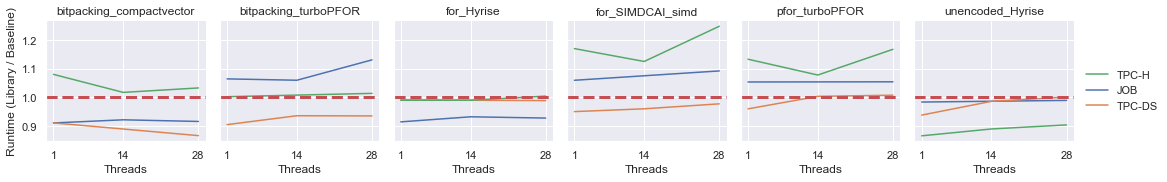

In [29]:
grid = sns.FacetGrid(without_dict, col=bn.PAPER_NAME, height=2.5)
grid.map_dataframe(sns.lineplot, x=bn.CLIENTS, y=bn.RUNTIME_TO_BASELINE, hue="Benchmark").set(xticks=[1,14,28])
for ax in grid.axes.flatten():
    ax.axhline(y=1, color='r', linewidth=3, linestyle='--')
grid.set_titles(col_template="{col_name}")
grid.set_ylabels("Runtime (Library / Baseline)")
grid.set_xlabels("Threads")
grid.add_legend()
plt.savefig("visualizations/benchmarks_runtime_closer.svg", bbox_inches="tight")

# Rest

In [14]:
only_28_clients: DataFrame = low_level_mult[low_level_mult[bn.CLIENTS] == 28]
single_with_unencoded_baseline: DataFrame = bn.get_relative_to_baseline_low_level(low_level_single, baseline="Unencoded")
multi_with_unencoded_baseline: DataFrame = bn.get_relative_to_baseline_low_level(only_28_clients, baseline="Unencoded")
sns.catplot(data=only_28_clients, kind="bar", x=bn.QUERY_NAME, y=bn.AVG_DURATION, hue=bn.LIBRARY_NAME, height=90, aspect=2)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'SIMDCAI'),
  Text(1, 0, 'TurboPFOR'),
  Text(2, 0, 'CompactVector'),
  Text(3, 0, 'TurboPFOR_bitpacking'),
  Text(4, 0, 'Unencoded'),
  Text(5, 0, 'Dictionary'),
  Text(6, 0, 'FrameOfReference')])

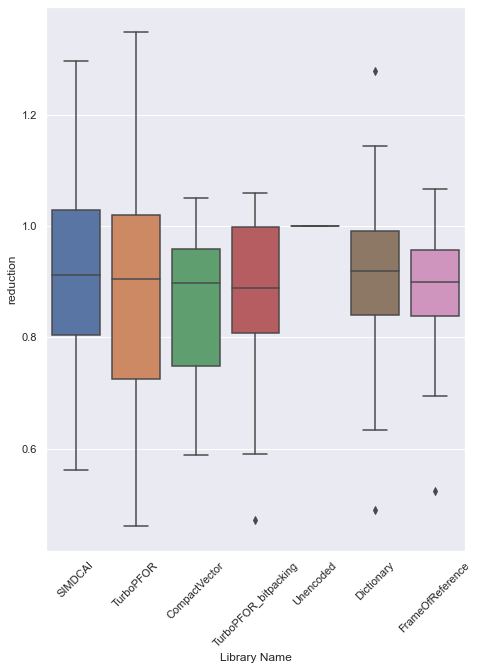

In [15]:
columns_to_merge: List[str] = [bn.QUERY_NAME, bn.LIBRARY_NAME, bn.RUNTIME_TO_BASELINE]
combined: DataFrame = single_with_unencoded_baseline.merge(multi_with_unencoded_baseline[columns_to_merge], on=[bn.LIBRARY_NAME, bn.QUERY_NAME])
combined[bn.REDUCTION] = [multi / single for single, multi
                         in zip(combined[f"{bn.RUNTIME_TO_BASELINE}_x"],
                                combined[f"{bn.RUNTIME_TO_BASELINE}_y"])]
sns.boxplot(data=combined, x=bn.LIBRARY_NAME, y=bn.REDUCTION)
plt.xticks(rotation=45)

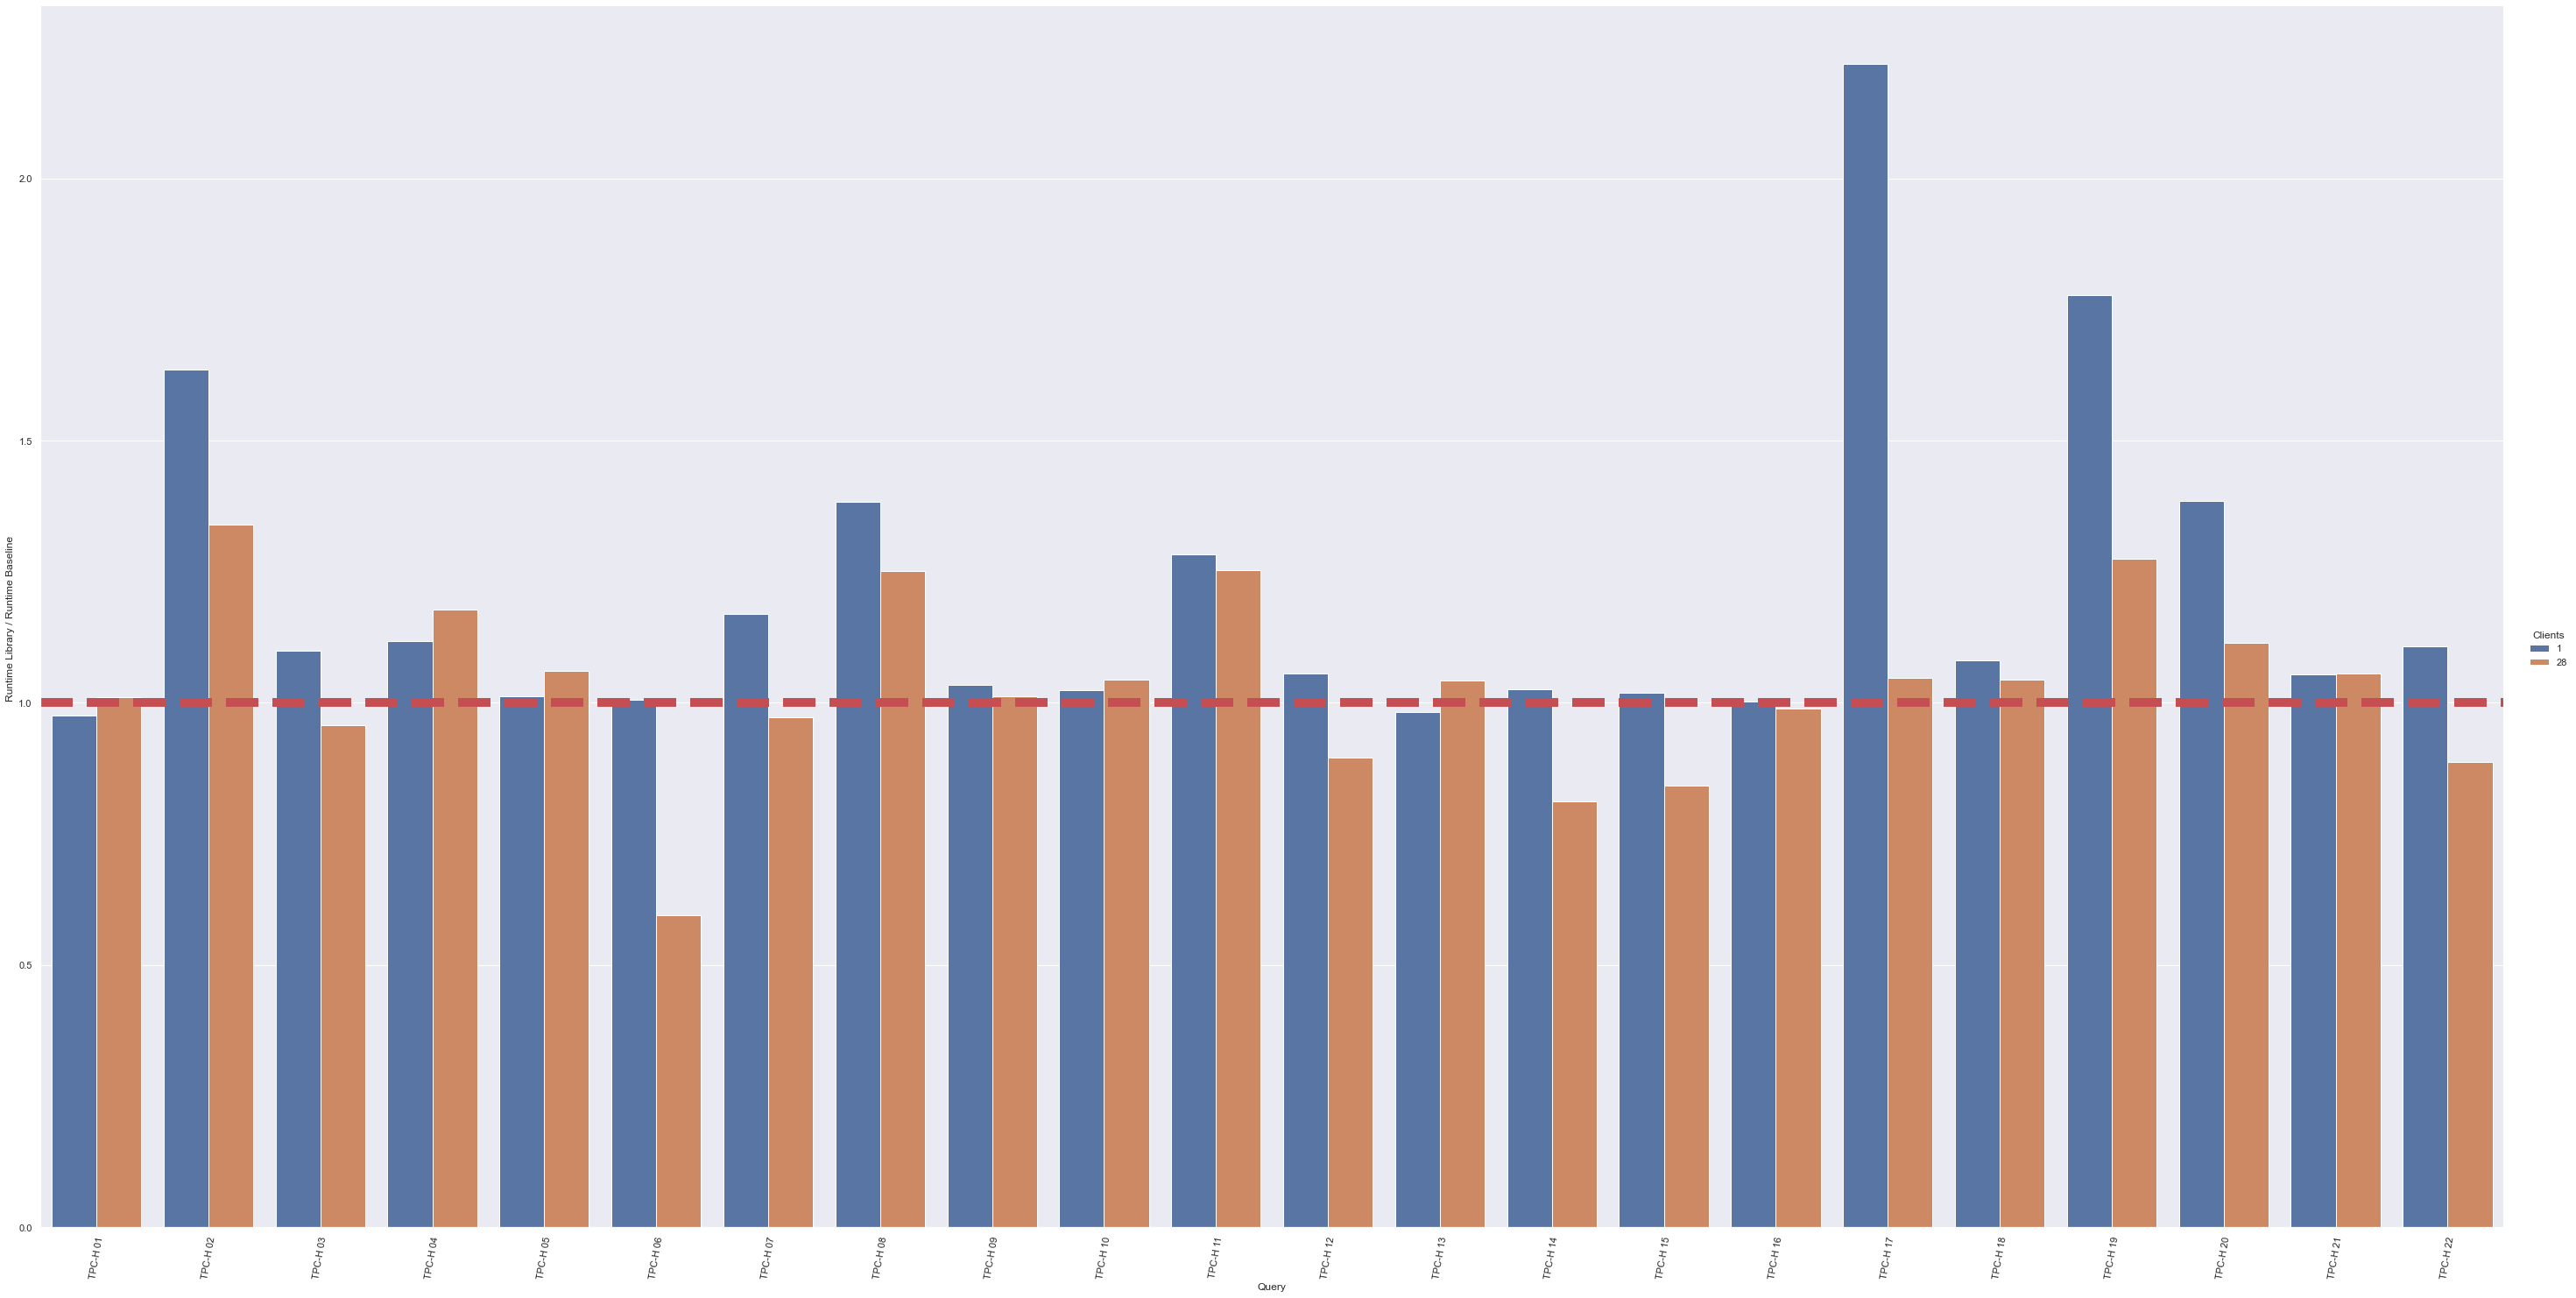

In [16]:
# Single vs. Multithreaded
appended: DataFrame = single_with_unencoded_baseline.append(multi_with_unencoded_baseline)
only_bitpacking: DataFrame = appended[appended[bn.LIBRARY_NAME] == "TurboPFOR_bitpacking"]
sns.catplot(data=only_bitpacking, x=bn.QUERY_NAME, y=bn.RUNTIME_TO_BASELINE, hue=bn.CLIENTS, kind="bar", height=20, aspect=2)
plt.xticks(rotation=80)
plt.axhline(y=1, color='r', linewidth=10, linestyle='--')
plt.savefig("visualizations/single_multithreaded.svg", bbox_inches="tight")

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'bitpacking_compactvector'),
  Text(1, 0, 'bitpacking_turboPFOR'),
  Text(2, 0, 'dictionary_Hyrise'),
  Text(3, 0, 'for_Hyrise'),
  Text(4, 0, 'for_SIMDCAI_simd'),
  Text(5, 0, 'pfor_turboPFOR'),
  Text(6, 0, 'unencoded_Hyrise')])

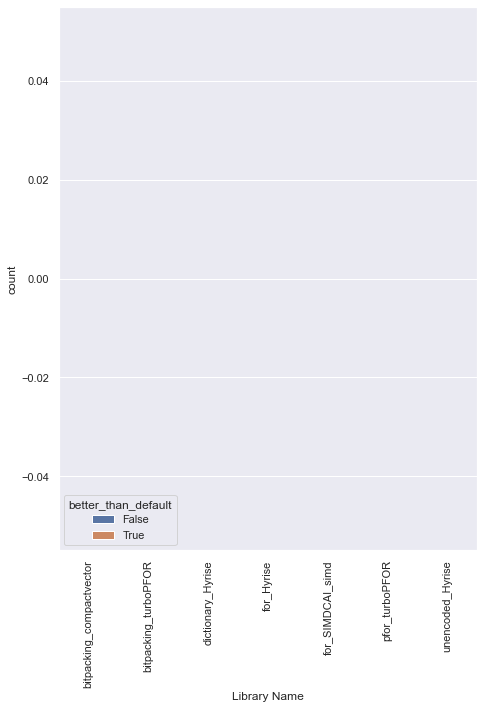

In [17]:
is_better_single: DataFrame = single_with_unencoded_baseline.copy()
is_better_multi: DataFrame = multi_with_unencoded_baseline.copy()
is_better_single[bn.BETTER_THAN_DEFAULT] = [rel_runtime < 1 for rel_runtime in is_better_single[bn.RUNTIME_TO_BASELINE]]
is_better_multi[bn.BETTER_THAN_DEFAULT] = [rel_runtime < 1 for rel_runtime in is_better_multi[bn.RUNTIME_TO_BASELINE]]
order: List[str] = sorted(is_better_single[bn.PAPER_NAME].drop_duplicates())
sns.countplot(data=is_better_single, x=bn.LIBRARY_NAME, hue=bn.BETTER_THAN_DEFAULT, order=order)
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'bitpacking_compactvector'),
  Text(1, 0, 'bitpacking_turboPFOR'),
  Text(2, 0, 'dictionary_Hyrise'),
  Text(3, 0, 'for_Hyrise'),
  Text(4, 0, 'for_SIMDCAI_simd'),
  Text(5, 0, 'pfor_turboPFOR'),
  Text(6, 0, 'unencoded_Hyrise')])

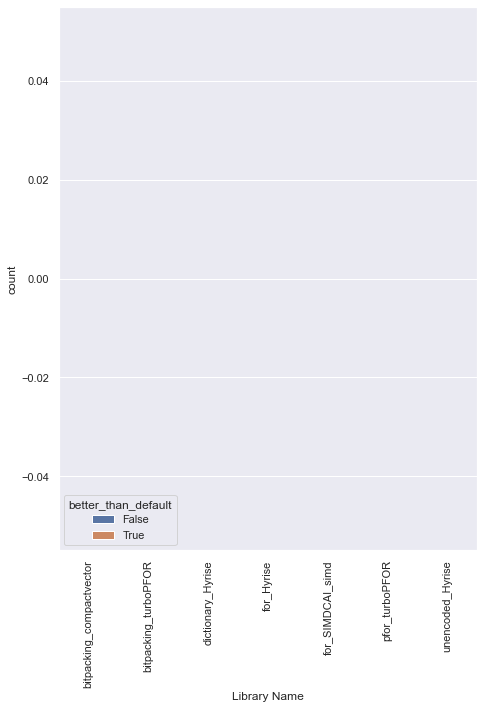

In [18]:
sns.countplot(data=is_better_multi, x=bn.LIBRARY_NAME, hue=bn.BETTER_THAN_DEFAULT, order=order)
plt.xticks(rotation=90)

In [19]:
integer_compressed: DataFrame = bn.load_sizes(sizes_folder / "sizes_Dictionary.txt")
dictionary: DataFrame = bn.load_sizes(sizes_folder / "sizes_Unencoded.txt")
columns_to_merge: List[str] = ["table_name", "chunk_id", "column_id", bn.SIZE_IN_BYTES]
merged: DataFrame = integer_compressed.merge(dictionary[columns_to_merge], on=["table_name", "chunk_id", "column_id"],
                                             suffixes=("","_baseline"))

In [20]:
# Get DB Columns where Int Compression Had the most impact
sizes_per_column = merged.groupby(["table_name", "column_name", bn.DATA_TYPE], as_index=False)[bn.SIZE_IN_BYTES, f"{bn.SIZE_IN_BYTES}_baseline"].sum()
sizes_per_column["compression"] = [x / y
                                     for x, y in zip(sizes_per_column[bn.SIZE_IN_BYTES],
                                                     sizes_per_column[f"{bn.SIZE_IN_BYTES}_baseline"])]
only_int_columns = sizes_per_column[sizes_per_column[bn.DATA_TYPE] == "int"]

<ipython-input-20-1237b227e0ae>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sizes_per_column = merged.groupby(["table_name", "column_name", bn.DATA_TYPE], as_index=False)[bn.SIZE_IN_BYTES, f"{bn.SIZE_IN_BYTES}_baseline"].sum()


In [21]:
dictionary.groupby([bn.DATA_TYPE], as_index=False)[bn.SIZE_IN_BYTES].sum()


,Data Type,Size (in Bytes)
0,float,676386560
1,int,1266756060
2,string,7950670887


In [22]:
sizes

,table_name,chunk_id,column_id,column_name,Data Type,distinct_value_count,encoding_type,vector_compression_type,Size (in Bytes),point_accesses,...,random_accesses,dictionary_accesses,Size (in GB),Library Name,Compression Scheme,Size (in Bytes)_baseline,Library Name_baseline,Compression Scheme_baseline,size_to_baseline,Benchmark
0,nation,0,0,n_nationkey,int,25,TurboPFOR,NULL,164,1428,...,872,0,1.640000e-07,CompactVector,bitpacking_compactvector,221,Dictionary,dictionary_Hyrise,0.742081,TPC-H
19144,store_sales,249,4,ss_cdemo_sk,int,5464,TurboPFOR,NULL,180364,0,...,92558,0,1.803640e-04,CompactVector,bitpacking_compactvector,153022,Dictionary,dictionary_Hyrise,1.178680,TPC-DS
19145,store_sales,249,5,ss_hdemo_sk,int,3826,TurboPFOR,NULL,141452,0,...,146,0,1.414520e-04,CompactVector,bitpacking_compactvector,146470,Dictionary,dictionary_Hyrise,0.965740,TPC-DS
19146,store_sales,249,6,ss_addr_sk,int,5411,TurboPFOR,NULL,155788,0,...,16150,0,1.557880e-04,CompactVector,bitpacking_compactvector,152810,Dictionary,dictionary_Hyrise,1.019488,TPC-DS
19147,store_sales,249,7,ss_store_sk,int,51,TurboPFOR,NULL,80012,0,...,274304,0,8.001200e-05,CompactVector,bitpacking_compactvector,65835,Dictionary,dictionary_Hyrise,1.215341,TPC-DS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12241,catalog_sales,190,1,cs_sold_time_sk,int,6901,NULL,NULL,270516,0,...,0,0,2.705160e-04,Unencoded,unencoded_Hyrise,158770,Dictionary,dictionary_Hyrise,1.703823,TPC-DS
12240,catalog_sales,190,0,cs_sold_date_sk,int,7,NULL,NULL,270516,0,...,1864134,0,2.705160e-04,Unencoded,unencoded_Hyrise,65659,Dictionary,dictionary_Hyrise,4.120014,TPC-DS
12224,catalog_sales,189,18,cs_quantity,int,100,NULL,NULL,270516,0,...,0,0,2.705160e-04,Unencoded,unencoded_Hyrise,66031,Dictionary,dictionary_Hyrise,4.096803,TPC-DS
12187,catalog_sales,188,15,cs_item_sk,int,36805,NULL,NULL,262324,0,...,0,0,2.623240e-04,Unencoded,unencoded_Hyrise,278386,Dictionary,dictionary_Hyrise,0.942303,TPC-DS


<AxesSubplot:xlabel='Clients', ylabel='Runtime Library / Runtime Baseline '>

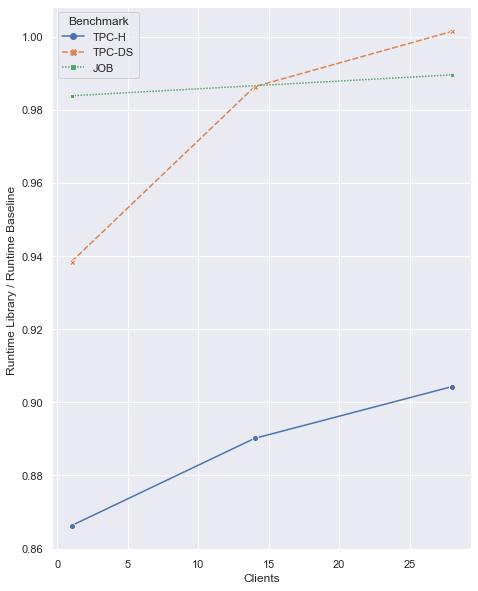

In [23]:
sns.lineplot(data=without_dict[without_dict[bn.LIBRARY_NAME] == "Unencoded"], x=bn.CLIENTS, y=bn.RUNTIME_TO_BASELINE, style="Benchmark", markers=True, hue="Benchmark")

In [24]:
def load_benchmark_with_sf(benchmark: str, sf: int) -> DataFrame:
    multi_threaded_folder: Path = Path(f"../data/nemea_{benchmark}_sf{sf}_multithreaded/")
    sizes_folder: Path = Path(f"../data/nemea_{benchmark}_sf10_singlethreaded/")
    df = bn.get_high_level(multi_threaded_folder, sizes_folder)
    return df[df[bn.CLIENTS] == 28]

all_combined: DataFrame = load_benchmark_with_sf("TPC-H", 1)\
                            .append(load_benchmark_with_sf("TPC-H", 10))\
                            .append(load_benchmark_with_sf("TPC-H",50))

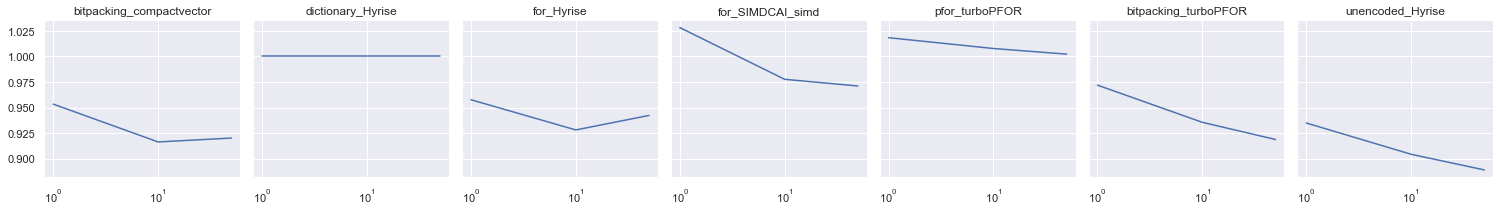

In [25]:
grid = sns.FacetGrid(all_combined, col=bn.PAPER_NAME)
grid.map_dataframe(sns.lineplot, x=bn.SCALE_FACTOR, y=bn.RUNTIME_TO_BASELINE).set(xscale="log")
grid.set_titles(col_template="{col_name}")

In [26]:
all_combined

,benchmark_run_name,Total Runtime (in seconds),avg_throughput,Library Name,Compression Scheme,with_lto,Clients,Scale Factor,multithreaded,float,int,string,Library Name_baseline,Total Runtime (in seconds)_baseline,int_baseline,Runtime Library / Runtime Baseline,size_to_baseline
7,./hyriseBenchmarkTPCH_CompactVector_28_sf1_shu...,4.407930,6.184807,CompactVector,bitpacking_compactvector,False,28,1,True,676386560.0,7.909348e+08,7.950671e+09,Dictionary,4.623782,1.372782e+09,0.953317,0.576155
8,./hyriseBenchmarkTPCH_Dictionary_28_sf1_shuffl...,4.623782,5.908670,Dictionary,dictionary_Hyrise,False,28,1,True,676386560.0,1.372782e+09,7.950671e+09,Dictionary,4.623782,1.372782e+09,1.000000,1.000000
9,./hyriseBenchmarkTPCH_FrameOfReference_28_sf1_...,4.427861,6.157377,FrameOfReference,for_Hyrise,False,28,1,True,676386560.0,9.912806e+08,7.950671e+09,Dictionary,4.623782,1.372782e+09,0.957627,0.722096
10,./hyriseBenchmarkTPCH_SIMDCAI_28_sf1_shuffled....,4.754145,5.745949,SIMDCAI,for_SIMDCAI_simd,False,28,1,True,676386560.0,6.464946e+08,7.950671e+09,Dictionary,4.623782,1.372782e+09,1.028194,0.470938
11,./hyriseBenchmarkTPCH_TurboPFOR_28_sf1_shuffle...,4.708573,5.799958,TurboPFOR,pfor_turboPFOR,False,28,1,True,676386560.0,6.514422e+08,7.950671e+09,Dictionary,4.623782,1.372782e+09,1.018338,0.474542
12,./hyriseBenchmarkTPCH_TurboPFOR_bitpacking_28_...,4.493912,6.069953,TurboPFOR_bitpacking,bitpacking_turboPFOR,False,28,1,True,676386560.0,6.557167e+08,7.950671e+09,Dictionary,4.623782,1.372782e+09,0.971913,0.477655
13,./hyriseBenchmarkTPCH_Unencoded_28_sf1_shuffle...,4.322660,6.302859,Unencoded,unencoded_Hyrise,False,28,1,True,676386560.0,1.266756e+09,7.950671e+09,Dictionary,4.623782,1.372782e+09,0.934875,0.922766
7,./hyriseBenchmarkTPCH_CompactVector_28_sf10_sh...,55.168860,0.497101,CompactVector,bitpacking_compactvector,False,28,10,True,676386560.0,7.909348e+08,7.950671e+09,Dictionary,60.205721,1.372782e+09,0.916339,0.576155
8,./tpch_Dictionary_28_sf10_shuffled.json,60.205721,0.460573,Dictionary,dictionary_Hyrise,False,28,10,True,676386560.0,1.372782e+09,7.950671e+09,Dictionary,60.205721,1.372782e+09,1.000000,1.000000
9,./tpch_FrameOfReference_28_sf10_shuffled.json,55.875643,0.490804,FrameOfReference,for_Hyrise,False,28,10,True,676386560.0,9.912806e+08,7.950671e+09,Dictionary,60.205721,1.372782e+09,0.928079,0.722096
